In [1]:
from __future__ import absolute_import
###
import SimpleITK as sitk
#from lib.SimpleITK import SimpleITK as sitk
import matplotlib.pyplot as plt
import warnings
from time import time
#import numba
from scipy.ndimage.filters import median_filter
import cv2 
import numpy as np
from math import atan2
from PIL import Image  
from PIL import ImageEnhance 
import pandas as pd
#from lib.myshow import myshow, myshow3d
#from lib.thinning import Skeleton
from lib.segWormPython.mainSegworm import get_contour_angles,getSkeleton
from utils import process_config,frame_factory,frame_diff,thresh_otsu,concatenate,resize_and_gray,show_img,open_op,PIL_filter,\
plt_show,shape_filter,fill_holes,geodesicActiveContourSegementation
from curvature import curvature_grad
%matplotlib inline
from ipywidgets import interact, FloatSlider
params=process_config('..\\config.cfg')
params['video_path']='D:\\dataset\\C.elegant\\429-2.avi'
params['video_path']='D:\\dataset\\worms\\441.avi'
filters=PIL_filter('EDGE_ENHANCE_MORE')
frames=frame_factory(params['video_path'])
activecontour=geodesicActiveContourSegementation(params)
fgbg = cv2.createBackgroundSubtractorMOG2()

In [2]:
color = [
(241,242,224), (196,203,128), (136,150,0), (64,77,0), 
(201,230,200), (132,199,129), (71,160,67), (32,94,27),
(130,224,255), (7,193,255), (0,160,255), (0,111,255),
(220,216,207), (174,164,144), (139,125,96), (100,90,69),
(252,229,179), (247,195,79), (229,155,3), (155,87,1),
(231,190,225), (200,104,186), (176,39,156), (162,31,123),
(210,205,255), (115,115,229), (80,83,239), (40,40,198)]
# Color Names
color_name = [
'teal01', 'teal02', 'teal03', 'teal04',
'green01', 'green02', 'green03', 'green04',
'amber01', 'amber02', 'amber03', 'amber04',
'bluegrey01', 'bluegrey02', 'bluegrey03', 'bluegrey04',
'lightblue01', 'lightblue02', 'lightblue03', 'lightblue04',
'purple01', 'purple02', 'purple03', 'purple04',
'red01', 'red02', 'red03', 'red04']
color_map={}
for i in range(len(color_name)):
    color_map[color_name[i]]=color[i]
color_map['yellow']=(255,255,0)
color_map['violet']=(148,0,211)
color_map['PaleTurquoise']=(175,238,238)
def plot_arrow(img,orgin, destination, angle=25., fraction=0.2,color1='purple02', color2='purple03',thicken =2):
    orgin = np.array(orgin,dtype=np.int)
    destination = np.array(destination,dtype=np.int)
    angle =angle/180.*np.pi
    length = np.linalg.norm(orgin- destination)
    short_length = length*fraction
    vector = orgin - destination
    vector_rotate = np.dot(np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]]),vector)*fraction
    end_point1 =vector_rotate+destination
    angle = -angle
    vector_rotate = np.dot(np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]]),vector)*fraction
    end_point2 =vector_rotate+destination
    cv2.line(img,tuple(orgin),tuple(destination),color_map[color1],thicken)
    cv2.line(img,tuple(end_point1.astype(np.int)),tuple(destination),color_map[color2],thicken)
    cv2.line(img,tuple(end_point2.astype(np.int)),tuple(destination),color_map[color2],thicken)
    return img
def add_arrow(img, skeleton):
    middle = skeleton[24]
    head = skeleton[0]
    tail = skeleton[48]
    img = plot_arrow(img,middle,head,color1='violet',color2='PaleTurquoise')
    img = plot_arrow(img,middle,tail,color1='yellow',color2='PaleTurquoise')
    return img
def plot_worm(img,body_data,undetected=True):
    skeleton, cnt_side1, cnt_side2, = body_data
    skeleton=skeleton.astype(np.int)
    cnt_side1=cnt_side1.astype(np.int)
    cnt_side2=cnt_side2.astype(np.int)
    if(len(skeleton)==0):
        return img
    if undetected:
        cv2.polylines(img, [skeleton], False, color_map['teal04'][::-1], 1)
        cv2.polylines(img, [cnt_side1], False, color_map['green04'][::-1], 1)
        cv2.polylines(img, [cnt_side2], False, color_map['purple04'][::-1], 1)
        cv2.circle(img,(skeleton[0][0],skeleton[0][1]), 2,  color_map['amber04'][::-1], -1)
        cv2.circle(img,(skeleton[-1][0],skeleton[-1][1]), 2,  color_map['lightblue04'][::-1], -1)
    else:
        cv2.polylines(img, [skeleton], False, color_map['red04'][::-1], 1)
        cv2.polylines(img, [cnt_side1], False, color_map['red04'], 1)
        cv2.polylines(img, [cnt_side2], False, color_map['red04'], 1)
        cv2.circle(img,(skeleton[0][0],skeleton[0][1]), 2,  color_map['red04'][::-1], -1)
        cv2.circle(img,(skeleton[-1][0],skeleton[-1][1]), 2,  color_map['red04'][::-1], -1)
    return img
def get_angle(skeleton):
    vec1 = skeleton[0]-skeleton[24]
    vec2 = skeleton[48]-skeleton[24]
    angle= atan2(vec1[1],vec1[0])- atan2(vec2[1],vec2[0])
    angle = angle if angle>0 else angle+2*np.pi
    return angle/np.pi*180.

def _curvature_fun(x_d, y_d, x_dd, y_dd):
    return (x_d*y_dd - y_d*x_dd)/(x_d*x_d + y_d*y_d)**1.5

def _gradient_windowed(X, points_window, axis):
    '''
    Calculate the gradient using an arbitrary window. The larger window make 
    this procedure less noisy that the numpy native gradient.
    '''
    w_s = 2*points_window
    
    #I use slices to deal with arbritary dimenssions 
    #https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html
    n_axis_ini = max(0, axis)
    n_axis_fin = max(0, X.ndim-axis-1)
    right_slice = [slice(None, None, None)]*n_axis_ini + [slice(None, -w_s, None)]
    left_slice = [slice(None, None, None)]*n_axis_ini + [slice(w_s, None, None)]
    
    right_pad = [(0,0)]*n_axis_ini + [(w_s, 0)] + [(0,0)]*n_axis_fin
    left_pad = [(0,0)]*n_axis_ini + [(0, w_s)] + [(0,0)]*n_axis_fin
    
    right_side = np.pad(X[right_slice], right_pad, 'edge')
    left_side = np.pad(X[left_slice], left_pad, 'edge')
    
    ramp = np.full(X.shape[axis]-2*w_s, w_s*2)
    
    ramp = np.pad(ramp,  pad_width = (w_s, w_s),  mode='linear_ramp', end_values = w_s)
    #ramp = np.pad(ramp,  pad_width = (w_s, w_s),  mode='constant', constant_values = np.nan)
    ramp_slice = [None]*n_axis_ini + [slice(None, None, None)] + [None]*n_axis_fin
                 
    grad = (left_side - right_side) / ramp[ramp_slice] #divide it by the time window
    
    return grad

def compute_curvature_grad(curve, points_window=None, axis=1, is_nan_border=True):
    '''
    Calculate the curvature using the gradient using differences similar to numpy grad
    
    x1, x2, x3
    
    grad(x2) = (x3-x1)/2
    
    '''
    
    #The last element must be the coordinates
    assert curve.shape[-1] == 2
    assert axis != curve.ndim - 1    
    
    if points_window is None:
        points_window = 1
    
    if curve.shape[1] <= points_window*4:
        return np.full((curve.shape[0], curve.shape[1]), np.nan)
    
    d = _gradient_windowed(curve, points_window, axis=axis)
    dd = _gradient_windowed(d, points_window, axis=axis)
    gx = d[..., 0]
    gy = d[..., 1]
    ggx = dd[..., 0]
    ggy = dd[..., 1]
    
    curvature_r =  _curvature_fun(gx, gy, ggx, ggy)
    if is_nan_border:
        #I cannot really trust in the border gradient
        w_s = 4*points_window
        n_axis_ini = max(0, axis)
        right_slice = [slice(None, None, None)]*n_axis_ini + [slice(None, w_s, None)]
        left_slice = [slice(None, None, None)]*n_axis_ini + [slice(-w_s, None, None)]
        curvature_r[right_slice] = np.nan
        curvature_r[left_slice] = np.nan
    
    return curvature_r
def get_length(skeletons):
    '''
    Calculate length using the skeletons
    '''
    
    delta_coords = np.diff(skeletons, axis=1)
    segment_sizes = np.linalg.norm(delta_coords, axis=2)
    w_length = np.sum(segment_sizes, axis=1)
    return w_length
#@numba.jit
def fillfnan(arr):
    '''
    fill foward nan values (iterate using the last valid nan)
    I define this function so I do not have to call pandas DataFrame
    '''
    out = arr.copy()
    for idx in range(1, out.shape[0]):
        if np.isnan(out[idx]):
            out[idx] = out[idx - 1]
    return out
def fillbnan(arr):
    '''
    fill foward nan values (iterate using the last valid nan)
    I define this function so I do not have to call pandas DataFrame
    '''
    out = arr.copy()
    for idx in range(out.shape[0]-1)[::-1]:
        if np.isnan(out[idx]):
            out[idx] = out[idx+1]
    return out
def nanunwrap(x):
    '''correct for phase change for a vector with nan values 
    '''
    bad = np.isnan(x)
    x = fillfnan(x)
    x = fillbnan(x)
    x = np.unwrap(x)
    x[bad] = np.nan
    return x

def _curvature_angles(skeletons, window_length = None, lengths=None):
    if window_length is None:
        window_length = 7

    points_window = int(round(window_length/2))
    
    def _tangent_angles(skels, points_window):
        '''this is a vectorize version to calculate the angles between segments
        segment_size points from each side of a center point.
        '''
        s_center = skels[:, points_window:-points_window, :] #center points
        s_left = skels[:, :-2*points_window, :] #left side points
        s_right = skels[:, 2*points_window:, :] #right side points
        
        d_left = s_left - s_center 
        d_right = s_center - s_right
        
        #arctan2 expects the y,x angle
        ang_l = np.arctan2(d_left[...,1], d_left[...,0])
        ang_r = np.arctan2(d_right[...,1], d_right[...,0])
        
        with warnings.catch_warnings():
            #I am unwraping in one dimension first
            warnings.simplefilter("ignore")
            ang = np.unwrap(ang_r-ang_l, axis=1);
        
        for ii in range(ang.shape[1]):
            ang[:, ii] = nanunwrap(ang[:, ii])
        return ang
    
    if lengths is None:
        #caculate the length if it is not given
        lengths = get_length(skeletons)
    
    #Number of segments is the number of vertices minus 1
    n_segments = skeletons.shape[1] -1 
    
    #This is the fraction of the length the angle is calculated on
    length_frac = 2*(points_window-1)/(n_segments-1)
    segment_length = length_frac*lengths
    segment_angles = _tangent_angles(skeletons, points_window)
    
    curvature = segment_angles/segment_length[:, None]
    
    return curvature
def parse_image(img,min_area= 500):
    (_,contours, _) = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    goodIndex =[]
    gravity= []
    areas = []
    cnts =[]
    boundboxs=[]
    for ii, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        if area > min_area:
            goodIndex.append(ii)
            M = cv2.moments(contour)
            gravity.append(( int(M['m10']/M['m00']),int(M['m01']/M['m00'])))
            areas.append(area)
            cnts.append(np.squeeze(contour, axis=1))
            boundboxs.append(cv2.boundingRect(contour))
            
    mask = np.zeros(img.shape, dtype=img.dtype)
    #mask.fill(255)
    mask=np.stack([mask,mask,mask],axis=2)
    for i,ii in enumerate(goodIndex):
        cv2.drawContours(mask, contours, ii, (255,0,0), cv2.FILLED)
        x,y,w,h= boundboxs[i]
        x0,y0 = gravity[i]
        #cv2.rectangle(mask,(x,y),(x+w,y+h),(0,255,0),2)
        cv2.circle(mask,(x0,y0),2,(30,125,255),-1)  
    return len(goodIndex),np.array(gravity),np.array(areas),np.array(cnts),np.array(boundboxs),mask


def worm_tracking(last_frame_data,cur_frame_data,max_dist_thresh=17):     
    
    count_1, gravity_1, areas_1 = last_frame_data
    count_2, gravity_2, areas_2 = cur_frame_data
    diff_gravity = [np.linalg.norm(gravity_2-it,axis=1) for it in gravity_1]
    diff_gravity = np.array(diff_gravity)
    min_dist = np.min(diff_gravity,axis=1)
    min_dist_index = np.argmin(diff_gravity,axis=1)
    is_valid_track = (areas_2[min_dist_index]>0.7*areas_1)&(areas_2[min_dist_index]<1.3*areas_1)&(min_dist<max_dist_thresh)
    #print("-"*20)
    #print(areas_2[min_dist_index]>0.65*areas_1,areas_2[min_dist_index]<1.35*areas_1,min_dist<max_dist_thresh)
    #print("-"*20)
    i= 0
    min_dist_index_dict={}
    for it,iu in zip(is_valid_track,min_dist_index):
        min_dist_index_dict[i] = iu if it else 100
        i+=1
    new_track = list(set(range(count_2)).difference(min_dist_index_dict.values()))
    return min_dist_index_dict, new_track

class track:
    track_id = 0
    def __init__(self, start_index,inter_frame_index):
        self.begin = start_index
        self.track_id = track.track_id
        track.track_id +=1
        self.inter_frames_index = [inter_frame_index]
    def add_track(self,inter_frame_index):
        self.inter_frames_index.append(inter_frame_index)
    
    def stop(self,end_index):
        self.end = end_index
        self.num_frames =self.end - self.begin+1
        

In [3]:
#params['video_path']='D:\\dataset\\worms\\448.avi'
frames=frame_factory(params['video_path'])
#[frames[i] for i in range(270)]
for i in range(0,frames.num_frames):
    img,gray=resize_and_gray(frames[i],True,scale=2)
    #gray=filters.filter(gray).astype(np.uint8)
    #gray=filter_img.filter(gray)
    fgmask = fgbg.apply(gray)

(1200, 1600, 3)


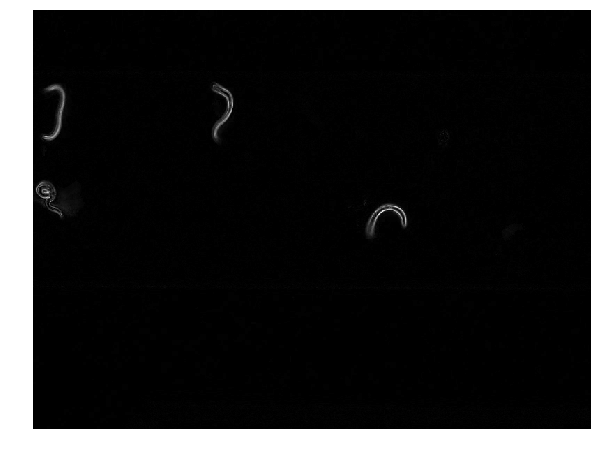

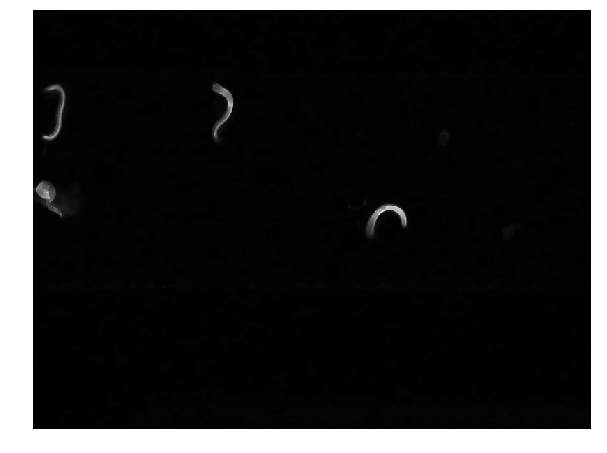

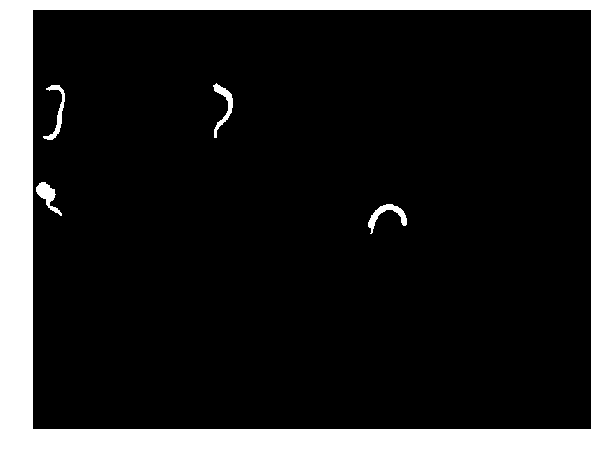

In [4]:
frames=frame_factory(params['video_path'])
print(frames[0].shape)
[frames[i] for i in range(625)]
img,gray=resize_and_gray(frames[625],True,scale=2)
diff=cv2.absdiff(gray,fgbg.getBackgroundImage())
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
plt_show(diff)
closing = cv2.morphologyEx(diff, cv2.MORPH_CLOSE, kernel,iterations = 2)
#closing = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel,iterations = 1)
plt_show(closing)
otsu = thresh_otsu(closing)
#plt_show(img)
plt_show(otsu)

In [10]:
frames=frame_factory(params['video_path'])
#[frames[i] for i in range(270)]
print(frames.size)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
videoWriter = cv2.VideoWriter('output.avi',fourcc, 10, (800,600))
worm_data_list=[]
for i in range(0,frames.num_frames):
    img,gray=resize_and_gray(frames[i],True,scale=2)
    diff=cv2.absdiff(gray,fgbg.getBackgroundImage())
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    closing = cv2.morphologyEx(diff, cv2.MORPH_CLOSE, kernel)
    #cv2.putText(otsu, 'frame index: ' + str(i), (40, 40), 2, 2, (0,0,0), thickness = 2)
    otsu = thresh_otsu(closing)
    cv2.imwrite('otsu'+str(i)+'.jpg',otsu)
    counts,gravity,areas,cnts,boundboxs,mask=parse_image(otsu,min_area=200)
    #print(counts)
    cv2.imshow('otsu',concatenate(img,otsu))
    worm_data_list.append((counts,gravity,areas,cnts,boundboxs))
    videoWriter.write(mask)
    #print(mask.shape)
    cv2.imshow('bs',np.concatenate([img,mask],axis=1))
    k = cv2.waitKey(1) 
    if k == 27:
        break
    else:
        continue
cv2.destroyAllWindows()
videoWriter.release()
np.save('worm_data.npy',worm_data_list)

(1600, 1200)


In [3]:
#################################################################################
#   Worm tracking code block
#################################################################################
worm_data_list=np.load('worm_data.npy')
track.track_id=0
track_list=[]
new_worm_list=[]
counts,gravity,areas,cnts,boundboxs = worm_data_list[0]
new_worm_list.append((counts,gravity,areas,cnts,boundboxs,np.arange(counts)))
for i in range(counts):
    track_list.append(track(0,i))
for frame_index in range(1,len(worm_data_list)):
    counts_cur, gravity_cur ,areas_cur ,cnts_cur, boundboxs_cur =worm_data_list[frame_index]
    #print(frame_index,"************",counts_cur,counts)
    min_dist_index, new_track = worm_tracking((counts,gravity,areas),(counts_cur,gravity_cur,areas_cur))
    obj_track_id={}
    #print(min_dist_index,new_track,new_worm_list[-1][5])
    #break
    
    for key, value in min_dist_index.items():
        track_id = new_worm_list[-1][5][key]
        if value < 100 and frame_index != len(worm_data_list)-1:
            track_list[track_id].add_track(value)
            obj_track_id[value] = track_id
        else:
            track_list[track_id].stop(frame_index - 1)
           
            #if track_list[track_id].num_frames >5:
              
    for it in new_track:
        track_list.append(track(frame_index,it))
        obj_track_id[it] = track.track_id-1
        #print("new_track",frame_index)
    track_id_list = [iu for it,iu in obj_track_id.items()]
    #print("obj_track_id",obj_track_id,"track_id_list",track_id_list)
    new_worm_list.append((counts_cur, gravity_cur ,areas_cur ,cnts_cur, boundboxs_cur, np.array(track_id_list)))
    counts,gravity,areas,cnts,boundboxs = counts_cur, gravity_cur ,areas_cur ,cnts_cur, boundboxs_cur
###############################################################################
#   Save the tracking data
###############################################################################
track_list = filter(lambda x: x.num_frames>10,track_list)
track_list = list(track_list)
track_id_list=[it.track_id for it in track_list]
print(track_id_list)
track_id_map={}
i=0
for it in track_id_list:
    track_id_map[it] =i
    i+=1
print(track_id_map)

track_data = []
for it in track_list:
    contour_squence = []
    ske_len_squence  = []
    
    skeleton_squence =[]
    
    cnt_side1_squence = []
    cnt_side2_squence = []
    cnt_area_squence = []
    angle_squence =[]
    prev_skeleton = np.zeros(0)
    for i in range(it.begin, it.end+1):
        #assert(it.track_id== new_worm_list[i][5][it.inter_frames_index[i - it.begin]])
        cnt = new_worm_list[i][3][it.inter_frames_index[i - it.begin]]
        skeleton, ske_len, cnt_side1, cnt_side2, cnt_widths, cnt_area = getSkeleton(cnt,  prev_skeleton=  prev_skeleton)
        
        angle = get_angle(skeleton) if len(skeleton) !=0 else None
        angle_squence.append(angle)
        
        prev_skeleton = skeleton
        
        contour_squence.append(cnt)
        ske_len_squence.append(ske_len)
        skeleton_squence.append(skeleton)
        cnt_side1_squence.append(cnt_side1)
        cnt_side2_squence.append(cnt_side2)
        cnt_area_squence.append(cnt_area)
    track_data.append(np.array([track_id_map[it.track_id],
                                it.num_frames,          it.begin,          it.end,
                                np.array(contour_squence),
                               np.array(ske_len_squence,dtype=np.object),
                               np.array(skeleton_squence),
                               np.array(cnt_side1_squence),
                               np.array(cnt_side2_squence),
                               np.array(cnt_area_squence,dtype=np.object),np.array(angle_squence)],dtype = np.object))
#######################################################################
#
########################################################################
frame_data=[]
for frame_index in range(0, len(new_worm_list)):
    counts_cur, gravity_cur ,areas_cur ,cnts_cur, boundboxs_cur, track_id_list = new_worm_list[frame_index]
    track_id_list = [track_id_map.get(it,-1) for it in track_id_list]
    
    skeletons = [track_data[it][6][frame_index - track_data[it][2]] if it !=-1 else np.zeros(0) for it in track_id_list]
    
    angles = [track_data[it][10][frame_index-track_data[it][2]] if it !=-1 else None for it in track_id_list]
    
    length = [track_data[it][5][frame_index-track_data[it][2]] if it !=-1 else None for it in track_id_list]
    
    frame_data.append([counts_cur, gravity_cur ,areas_cur ,cnts_cur, boundboxs_cur, track_id_list,
                        np.array(skeletons,dtype= np.object),np.array(angles,dtype=np.object),np.array(length,dtype=np.object)])
    
    
np.save('frame_data.npy',frame_data)
# data_field in frame_data
#0      1        2     3    4         5             6         7      8
#conuts gravitys areas cnts boundboxs track_id_list skeletons angles length
np.save('track_data.npy',track_data)
# data field in track_data
#0        1          2     3   4               5               6                7             8             9            10
#track_id num_frames begin end contour_squence ske_len_squence skeleton_squence side1_squence side2_squence area_squence angle_sq

[0, 1, 6, 7, 9, 10, 11, 12, 16, 19, 20, 21, 22, 24, 25, 27, 39, 48, 49, 51, 63, 65, 73, 74, 75, 78, 79, 80, 81, 84, 85, 86, 90, 91, 103, 107, 110, 111, 114, 117, 121, 122, 123, 125, 127, 131, 132, 134, 135, 136, 140, 142, 143, 144, 145, 146, 147, 150, 151, 152, 161, 162, 164, 167, 170, 173, 174]
{0: 0, 1: 1, 131: 45, 132: 46, 150: 57, 6: 2, 7: 3, 136: 49, 9: 4, 10: 5, 11: 6, 12: 7, 142: 51, 143: 52, 16: 8, 145: 54, 146: 55, 19: 9, 20: 10, 21: 11, 22: 12, 151: 58, 24: 13, 25: 14, 27: 15, 167: 63, 161: 60, 162: 61, 164: 62, 134: 47, 39: 16, 170: 64, 135: 48, 173: 65, 174: 66, 48: 17, 49: 18, 51: 19, 140: 50, 63: 20, 65: 21, 152: 59, 73: 22, 74: 23, 75: 24, 78: 25, 79: 26, 80: 27, 81: 28, 84: 29, 85: 30, 86: 31, 90: 32, 91: 33, 144: 53, 103: 34, 107: 35, 110: 36, 111: 37, 114: 38, 147: 56, 117: 39, 121: 40, 122: 41, 123: 42, 125: 43, 127: 44}


In [5]:
frames=frame_factory('output.avi')
imgs = frame_factory(params['video_path'])

fourcc = cv2.VideoWriter_fourcc(*'XVID')
videoWriter = cv2.VideoWriter('wormtracking.avi',fourcc, 10, (800*2,600))
print(frames.num_frames)
new_worm_list =np.load('frame_data.npy')
for i in range(frames.num_frames-1):
    counts_cur, gravity_cur ,areas_cur ,cnts_cur, boundboxs_cur,track_id,skeletons, angles ,lengths =new_worm_list[i]
    img = frames[i]
    orgin_img ,_= resize_and_gray(imgs[i],True,scale=2)
    #print(skeletons[0])
    for it in range(counts_cur):
        x,y,w,h =boundboxs_cur[it]
        track_worm_id = track_id[it]
        angle = str(angles[it])[:6] if angles[it] else 'None'
        length =str(lengths[it])[:5] if lengths[it] else 'None'
        cv2.putText(img, 'Frame index: ' + str(i), (10, 12), 4, 0.5, (90,120,255), thickness = 1)
        cv2.putText(img, 'TrackID: ' + str(track_worm_id), (x-14, y-4), 4, 0.5, (255,255,255), thickness = 1)
        cv2.putText(img, 'angle: ' +angle, (x-14, y-24), 4, 0.5, (255,255,255), thickness = 1)
        cv2.putText(img, 'length: ' + length, (x-14, y-44), 4, 0.5, (255,255,255), thickness = 1)
        img = add_arrow(img,skeletons[it]) if len(skeletons[it])!=0   else img
    showimg = np.concatenate((orgin_img,img),axis=1)
    cv2.imshow('img',showimg)
    cv2.imshow('worm',img)
    videoWriter.write(showimg)
    k = cv2.waitKey(0) 
    if k == 27:
        break
    else:
        continue
cv2.destroyAllWindows()
videoWriter.release()

1584


C:\Users\steve\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [8]:
cv2.imwrite('worm_image2.jpg',frame_factory('wormtracking2.avi')[0])


True

In [5]:
from pylab import *  
myfont=matplotlib.font_manager.FontProperties(fname=r'C:/Windows/Fonts/msyh.ttc')
mpl.rcParams['axes.unicode_minus'] = False 
plt.clf() 


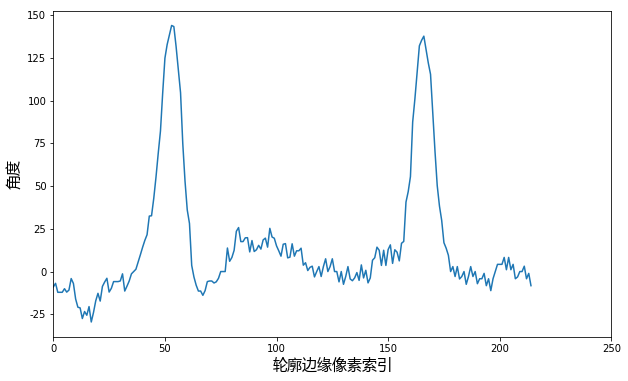

In [14]:
new_worm_list =np.load('frame_data.npy')
cnt =new_worm_list[199][3][0]
skeleton, ske_len, cnt_side1, cnt_side2, cnt_widths, cnt_area,freq = getSkeleton(cnt)
freq = np.concatenate([freq[50:],freq[:50]])
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(freq)
plt.xlabel(u'轮廓边缘像素索引',fontproperties=myfont,fontsize=15)  
plt.ylabel(u'角度',fontproperties=myfont,fontsize=15)
plt.xlim(0,250)
plt.savefig('./test1.jpg',dpi=600)
plt.show()

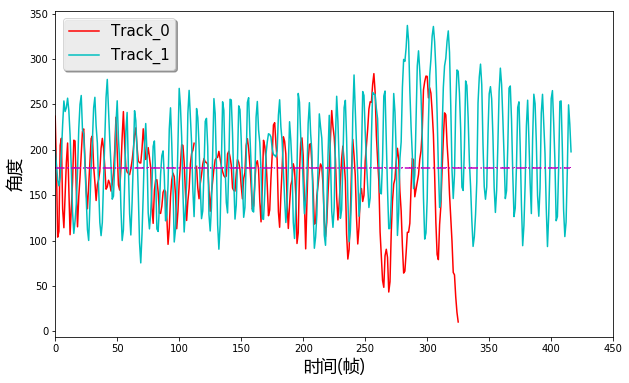

In [15]:
track_data = np.load('track_data.npy')
track_0=track_data[0]
track_1=track_data[1]
track_0_angle = track_0[10]
track_1_angle = track_1[10]
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.arange(len(track_0_angle)),track_0_angle,'r-',label='Track_0')
ax.plot(np.arange(len(track_1_angle)),track_1_angle,'c-',label='Track_1')
plain_curve_x =np.arange(0,len(track_1_angle),5)
plain_curve_y = np.full((len(plain_curve_x),),180)
ax.plot(plain_curve_x,plain_curve_y,'m,-.')
legend = ax.legend(loc='upper left', shadow=True, fontsize=15)

plt.xlabel(u'时间(帧)',fontproperties=myfont,fontsize=17)  
plt.ylabel(u'角度',fontproperties=myfont,fontsize=17)
plt.xlim(0,450)
plt.savefig('./test2.jpg',dpi=600)
plt.show()

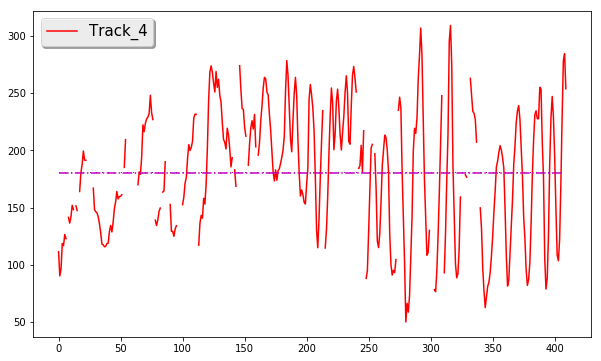

In [29]:
track_data = np.load('track_data.npy')
track_0=track_data[4]

track_0_angle = track_0[10]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(np.arange(len(track_0_angle)),track_0_angle,'r-',label='Track_4')
plain_curve_x =np.arange(0,len(track_0_angle),5)
plain_curve_y = np.full((len(plain_curve_x),),180)
ax.plot(plain_curve_x,plain_curve_y,'m,-.')
legend = ax.legend(loc='upper left', shadow=True, fontsize=15)
plt.show()

In [14]:
fourcc = cv2.VideoWriter_fourcc(*'XVID')
videoWriter = cv2.VideoWriter('output200.avi',fourcc, 10, (470,330))
frames = frame_factory(video_path)
for i in range(frames.num_frames):
    frame= frames[i]
    w=470
    h=330
    x=600
    y=500
    #cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
    cv2.imshow('img',frame)
    videoWriter.write(frame[500:830,600:1070,:])
    k = cv2.waitKey(300) 
    if k == 27:
        break
    else:
        continue
cv2.destroyAllWindows()
videoWriter.release()

In [106]:
frames = frame_factory('F:\\circle.mp4')
[frames[i] for i in range(50)]
cv2.imwrite('D:\\hehe\\circle_img.jpg',frames[50])

True

In [10]:
def to_binary(img,pixel,thresh=25):
    sub_img=img-pixel
    norm_img=np.linalg.norm(sub_img,axis=2).astype(np.uint8)
    norm_img = cv2.threshold(norm_img,thresh,255,cv2.THRESH_BINARY)[1]
    return norm_img 


(512, 688, 3)


NameError: name 'to_binary' is not defined

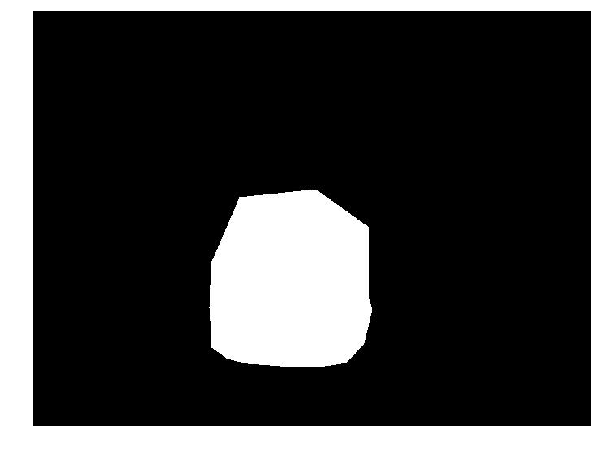

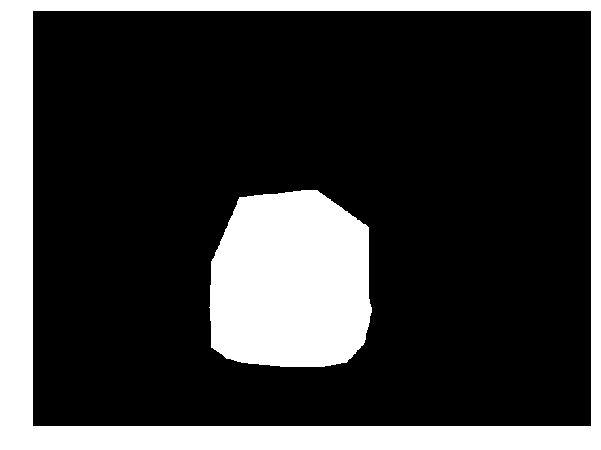

In [5]:
frames = frame_factory('F:\\circle.mp4')
mask = cv2.imread('D:\\hehe\\circle_mask.jpg')
print(mask.shape)
mask= cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
plt_show(mask)
mask =cv2.threshold(mask,127,255,cv2.THRESH_BINARY)[1]
plt_show(mask)
former_img = to_binary(frames[0],red_pixel,thresh=30)
area_list=[]
for i in range(1,frames.num_frames):
    bin_img = to_binary(frames[i],red_pixel,thresh=30)
    #fill_hole_img = fill_holes(bin_img)
    diff_img = cv2.absdiff(bin_img,former_img)
    diff_img = cv2.bitwise_and(diff_img,mask)
    #print(np.unique(diff_img))
    cv2.imshow('img',concatenate(frames[i],diff_img))
    diff_img[diff_img==255]=1
    areas = diff_img.sum()
    area_list.append(areas)
    #cv2.imshow('img',diff_img)
    former_img= bin_img
    k = cv2.waitKey(30) 
    if k == 27:
        break
    else:
        continue
cv2.destroyAllWindows()

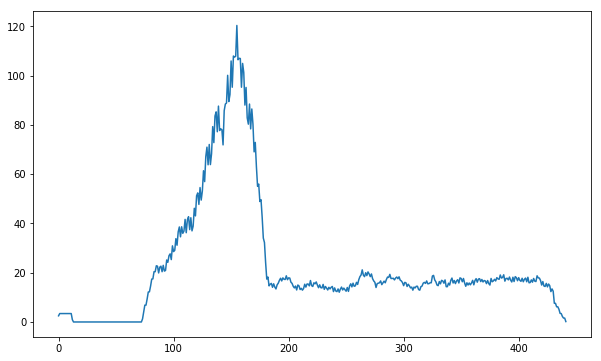

In [110]:
import scipy
area_arr = np.array(area_list)
kernel =np.full((12,),1/12.)
area_arr = scipy.signal.convolve(area_arr, kernel)
fig, ax = plt.subplots(figsize=(10,6))
#ax.plot(area_list)
ax.plot(area_arr)
plt.show()
plt.savefig("circle.jpg")

(512, 688, 3)


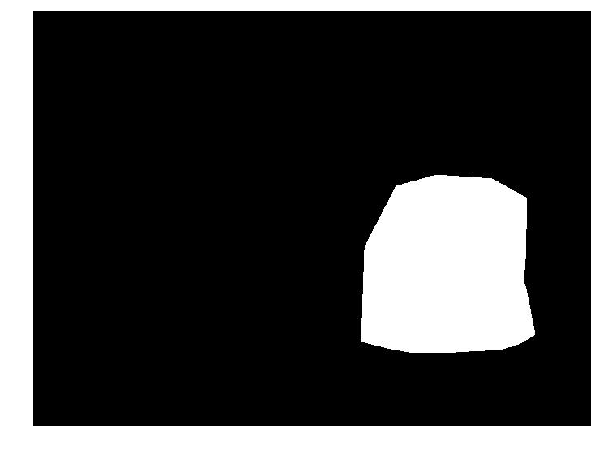

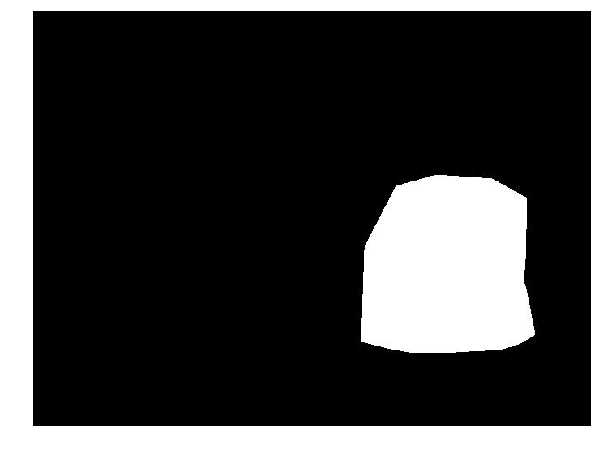

In [100]:
mask_ = cv2.imread('D:\\hehe\\circle_mask.jpg')
print(mask_.shape)
plt_show(mask_)
mask_ = cv2.cvtColor(mask_, cv2.COLOR_BGR2GRAY)
plt_show(mask_)

<h1 align="center">线虫的图像处理演示</h1>

<b>下面的代码块主要做了一下几件事情：</b>
+ <b>读取一帧视频</b>
+ <b>调整图像的大小尺寸变为原来的一半并且灰度化</b>
+ <b>更新背景像素，fgbg.apply(gray)将返回前景像素。阴影的灰度值为128，前景像素的灰度值为255.由于背景估计的不准确。导致前景目标的不连续。所以需要后续的处理</b>
+ <b>fgbg.getBackgroundImage() 将返回背景图片，与原图相减可以得到前景的灰度图</b>
+ <b>我们接下来需要对bg进行处理来得到最终的初始轮廓，用于水平集图像分割。初始轮廓应包含真正的轮廓</b>

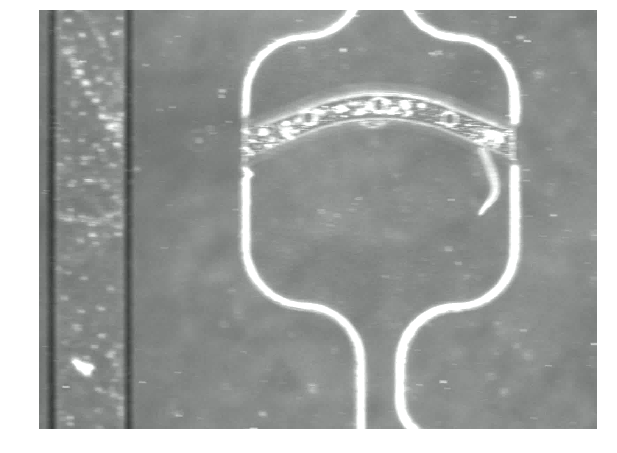

In [174]:
plt_show(frames[230])

 ## 下面的代码块主要做了一下几件事情，为了尽可能的连接断裂的轮廓
1. <b>距离变换</b>
2. <b>闸值化</b>

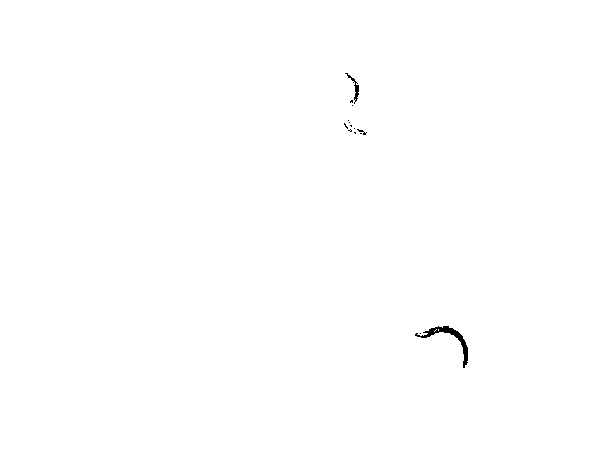

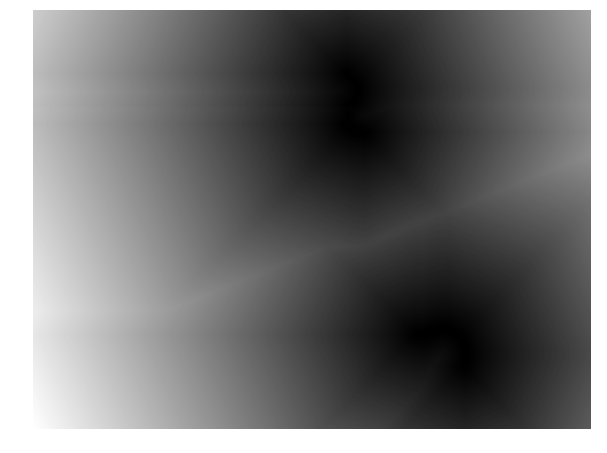

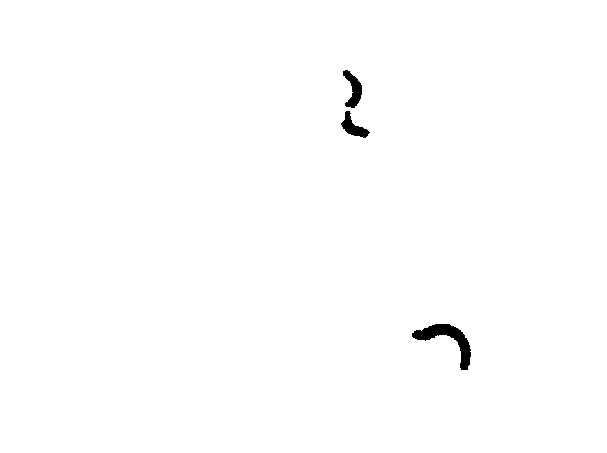

In [136]:
reverse=255-bg
plt_show(reverse)
dist_transform = cv2.distanceTransform(reverse,cv2.DIST_L2,3)
plt_show(dist_transform)
_,ret=cv2.threshold(dist_transform,4,255,cv2.THRESH_BINARY)
plt_show(ret)

 ## 下面的代码主要做了一下几件事：
+ <b>通过形状滤波过滤掉，面积太小的连通域</b>
+ <b>空洞填充</b>
+ <b>通过形态学闭操作，连接不连续的的部分，确保真正的轮廓被包含在里面</b>

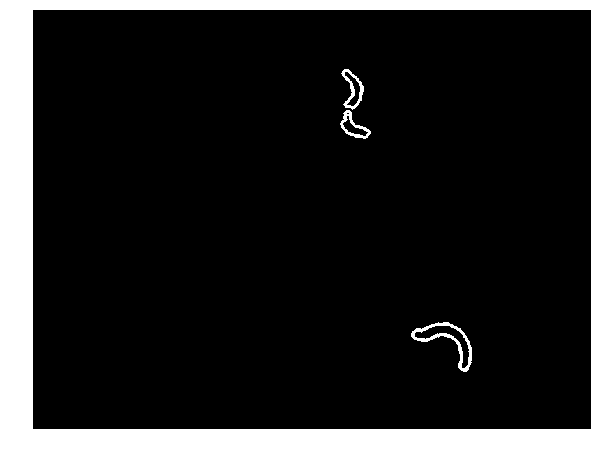

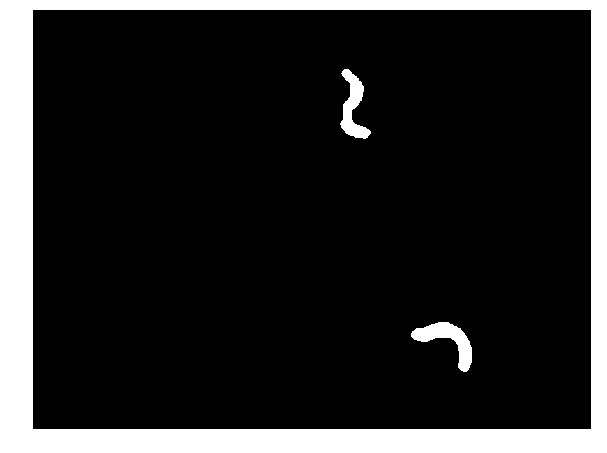

In [137]:
ret=255-ret
shape_filtered=shape_filter(ret.astype(np.uint8))
shape_filtered=shape_filtered.astype(np.uint8)
plt_show(shape_filtered)
holes=fill_holes(shape_filtered)
init_contour=cv2.morphologyEx(holes,cv2.MORPH_CLOSE,np.ones((3,3),np.uint8),iterations = 7)
plt_show(init_contour)

 # 下面的程序利用The ITK Software提供的level set分割的一个类实例化一个对象并，设置其参数可以控制曲线演化过程中所受到的不同力的大小的影响。
 
 # 最下面两行为一个递归的高斯滤波器，sigma为所用核的大小

In [138]:
geodesicActiveContour = sitk.GeodesicActiveContourLevelSetImageFilter()
geodesicActiveContour.SetPropagationScaling(-0.9)
geodesicActiveContour.SetCurvatureScaling(1.)
geodesicActiveContour.SetAdvectionScaling(1.5)
geodesicActiveContour.SetMaximumRMSError(0.01)
geodesicActiveContour.SetNumberOfIterations(35)
gradientMagnitude = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
gradientMagnitude.SetSigma(3)

# 下面

In [139]:
init_contour = sitk.GetImageFromArray(init_contour)
init_contour = sitk.SignedMaurerDistanceMap(init_contour, 
insideIsPositive=False, useImageSpacing=False)
featureImage=sitk.GetImageFromArray(gray)
featureImage = sitk.BoundedReciprocal(gradientMagnitude.Execute(featureImage))
featureImage = sitk.Cast( featureImage, init_contour.GetPixelID()) 
levelset = geodesicActiveContour.Execute( init_contour, featureImage )
contour=levelset<0

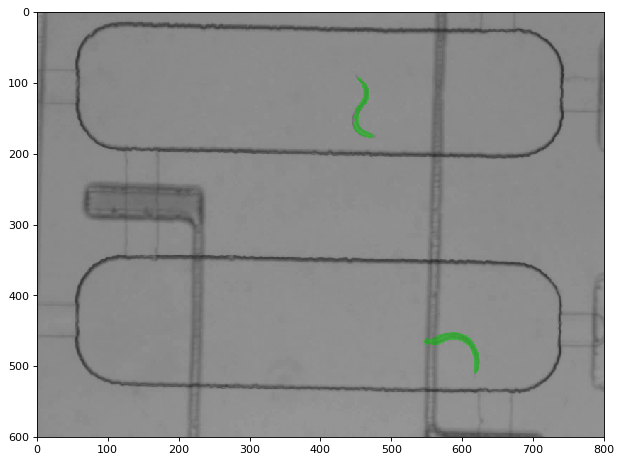

In [140]:
myshow(sitk.LabelOverlay(sitk.GetImageFromArray(gray), contour))

In [141]:
contour=sitk.GetArrayFromImage(contour)

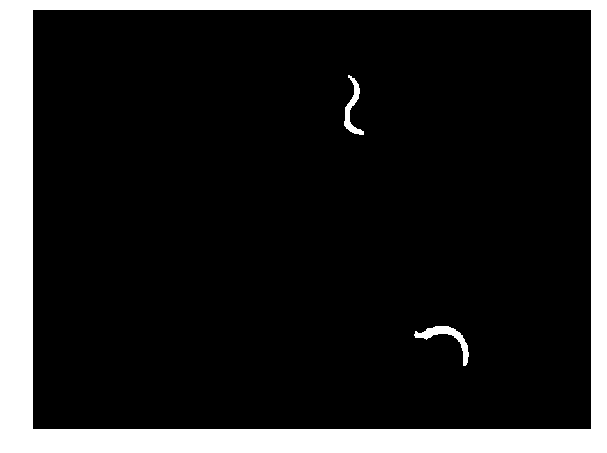

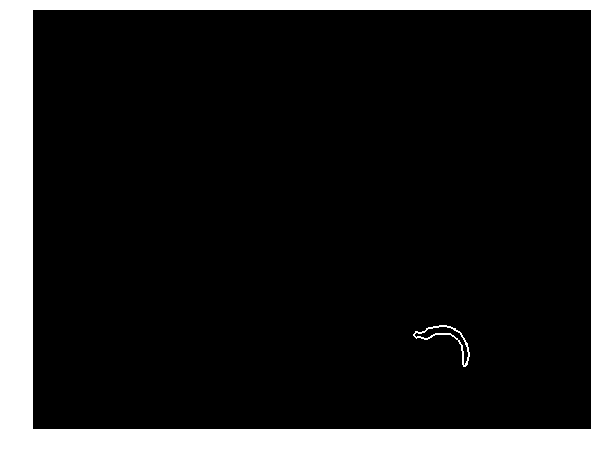

In [142]:
plt_show(contour)
(_,cnts, _) = cv2.findContours(contour.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
mask=np.zeros(contour.shape)
plt_show(cv2.drawContours(mask,cnts[0],-1,255,2))
cnts2=np.squeeze(cnts[0], axis=1)
output=getSkeleton(cnts2)

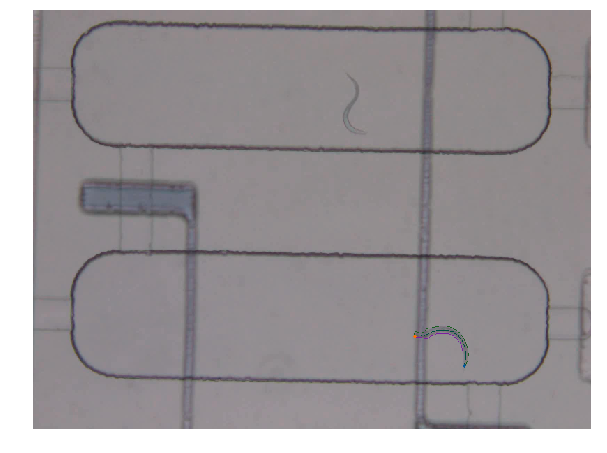

In [143]:
img=plot_worm(img,output,undetected=True)
plt_show(img)

In [159]:
def _curvature_fun(x_d, y_d, x_dd, y_dd):
    return (x_d*y_dd - y_d*x_dd)/(x_d*x_d + y_d*y_d)**1.5

def _gradient_windowed(X, points_window, axis):
    '''
    Calculate the gradient using an arbitrary window. The larger window make 
    this procedure less noisy that the numpy native gradient.
    '''
    w_s = 2*points_window
    
    #I use slices to deal with arbritary dimenssions 
    #https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html
    n_axis_ini = max(0, axis)
    n_axis_fin = max(0, X.ndim-axis-1)
    right_slice = [slice(None, None, None)]*n_axis_ini + [slice(None, -w_s, None)]
    left_slice = [slice(None, None, None)]*n_axis_ini + [slice(w_s, None, None)]
    
    right_pad = [(0,0)]*n_axis_ini + [(w_s, 0)] + [(0,0)]*n_axis_fin
    left_pad = [(0,0)]*n_axis_ini + [(0, w_s)] + [(0,0)]*n_axis_fin
    
    right_side = np.pad(X[right_slice], right_pad, 'edge')
    left_side = np.pad(X[left_slice], left_pad, 'edge')
    
    ramp = np.full(X.shape[axis]-2*w_s, w_s*2)
    
    ramp = np.pad(ramp,  pad_width = (w_s, w_s),  mode='linear_ramp', end_values = w_s)
    #ramp = np.pad(ramp,  pad_width = (w_s, w_s),  mode='constant', constant_values = np.nan)
    ramp_slice = [None]*n_axis_ini + [slice(None, None, None)] + [None]*n_axis_fin
                 
    grad = (left_side - right_side) / ramp[ramp_slice] #divide it by the time window
    
    return grad

def compute_curvature_grad(curve, points_window=None, axis=1, is_nan_border=True):
    '''
    Calculate the curvature using the gradient using differences similar to numpy grad
    
    x1, x2, x3
    
    grad(x2) = (x3-x1)/2
    
    '''
    
    #The last element must be the coordinates
    assert curve.shape[-1] == 2
    assert axis != curve.ndim - 1    
    
    if points_window is None:
        points_window = 1
    
    if curve.shape[0] <= points_window*4:
        return np.full((curve.shape[0], curve.shape[1]), np.nan)
    
    d = _gradient_windowed(curve, points_window, axis=axis)
    dd = _gradient_windowed(d, points_window, axis=axis)
    gx = d[..., 0]
    gy = d[..., 1]
    ggx = dd[..., 0]
    ggy = dd[..., 1]
    
    curvature_r =  _curvature_fun(gx, gy, ggx, ggy)
    if is_nan_border:
        #I cannot really trust in the border gradient
        w_s = 4*points_window
        n_axis_ini = max(0, axis)
        right_slice = [slice(None, None, None)]*n_axis_ini + [slice(None, w_s, None)]
        left_slice = [slice(None, None, None)]*n_axis_ini + [slice(-w_s, None, None)]
        curvature_r[right_slice] = np.nan
        curvature_r[left_slice] = np.nan
    
    return curvature_r

In [166]:
#cur=compute_curvature_grad(output[0][None,:,:],is_nan_border=False)
#cur
print(output[0][None,:,:].shape)

(1, 49, 2)


In [269]:
lsFilter = sitk.ThresholdSegmentationLevelSetImageFilter()
lsFilter.SetLowerThreshold(lower_threshold)
lsFilter.SetUpperThreshold(upper_threshold)
lsFilter.SetMaximumRMSError(0.02)
lsFilter.SetNumberOfIterations(100)
lsFilter.SetCurvatureScaling(1)
lsFilter.SetPropagationScaling(1)
#lsFilter.ReverseExpansionDirectionOn()
ls = lsFilter.Execute(init_ls, sitk.Cast(absdiff, sitk.sitkFloat32))

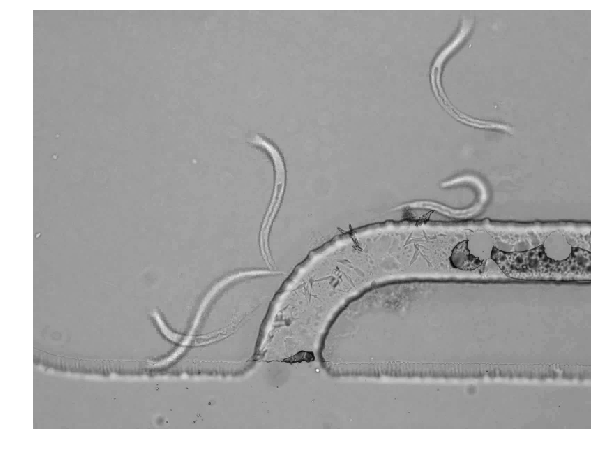

In [15]:
plt_show(grayg)

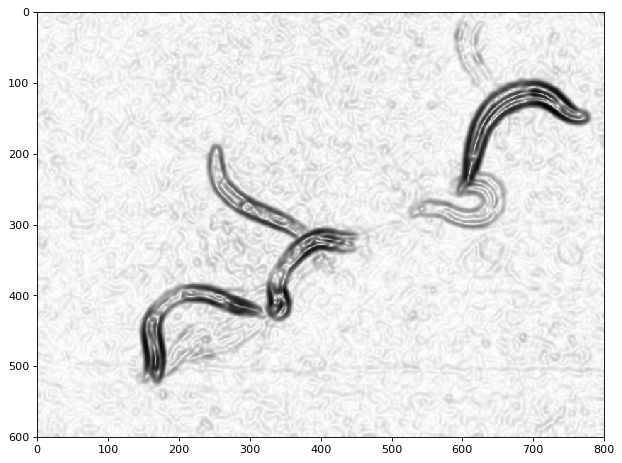

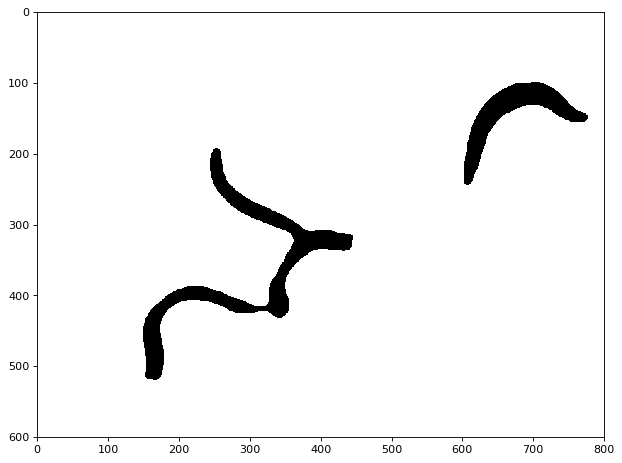

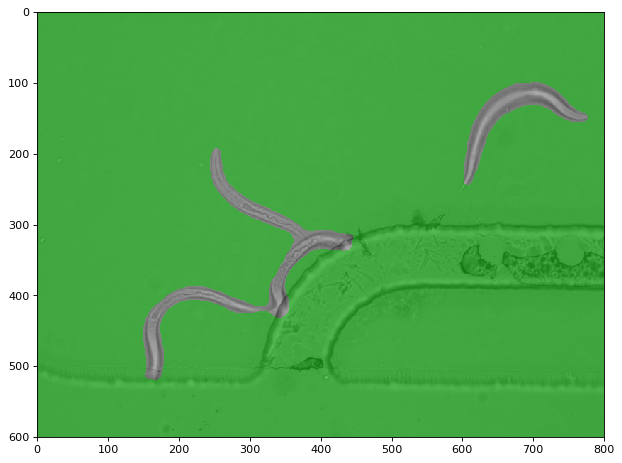

In [33]:
gradientMagnitude = sitk.GradientMagnitudeRecursiveGaussianImageFilter()
gradientMagnitude.SetSigma(3.)
featureImage = sitk.BoundedReciprocal( gradientMagnitude.Execute( absdiff ))
featureImage = sitk.Cast( featureImage, init_ls.GetPixelID()) 
myshow(featureImage)
geodesicActiveContour = sitk.GeodesicActiveContourLevelSetImageFilter()
geodesicActiveContour.SetPropagationScaling( -0.9 )
geodesicActiveContour.SetCurvatureScaling( 1. )
geodesicActiveContour.SetAdvectionScaling( 1.0 )
geodesicActiveContour.SetMaximumRMSError( 0.01 )
geodesicActiveContour.SetNumberOfIterations( 30 )
levelset = geodesicActiveContour.Execute( init_ls, featureImage )
myshow(levelset>0)
myshow(sitk.LabelOverlay(img, levelset>0))

In [6]:
contour=activecontour.execute(diff,bg)

[  0 255]


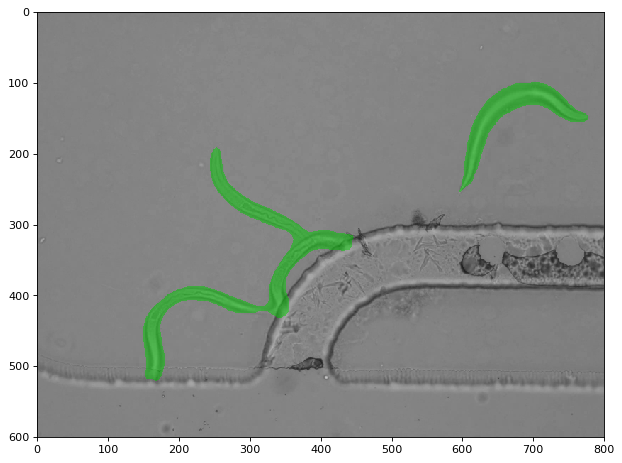

In [8]:
myshow(sitk.LabelOverlay(img, contour))

In [36]:
skeleton=sitk.GetArrayFromImage(levelset<0)

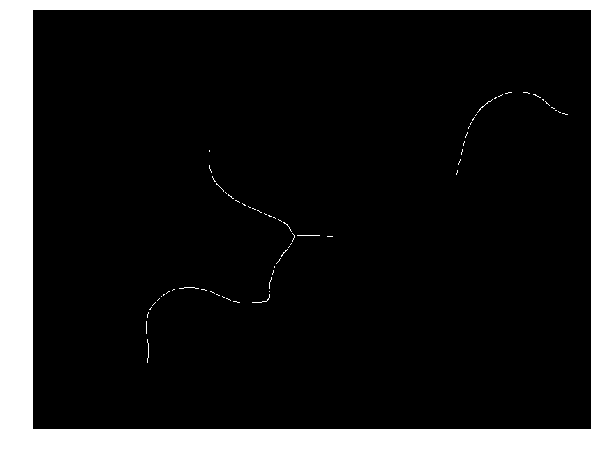

In [38]:
plt_show(Skeleton(skeleton))

In [4]:
import platform  
print(platform.python_version())

2.7.13
